# Streptomyce antibiotics evolution


## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Define environmental parameters

In [2]:
def calculate_radius_vectors(radius):
    radius_vectors = []
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if i**2+j**2 <= radius**2:
                radius_vectors.append((i,j))
    return radius_vectors

In [3]:
# World Parameters
field_size = (80, 80)  # Lattice size
# it is hard coaded in cell_replication method
eta = 8  # Neighborhood size for replication
tau_s = 800  # Growth cycle duration
xi = 0.001  # Fraction of spores to seed a growth cycle

# Replication Parameters
alpha_g = 0.1  # Max replication probability per unit time
h_g = 10  # No. of growth genes for 1/2 max growth rate
beta_r = 0.3  # Antibiotic resistance factor
mu_d = 0.001  # Duplication/deletion probability per gene
mu_f = 0.01  # Fragile site‐induced deletion probability (per fragile site)
mu_n = 0.01  # Probability of new fragile site formation per genome
mu_a = 0.005  # Probability of antibiotic-type mutation (per antibiotic gene)

# Antibiotic Production Parameters
alpha_a = 1  # Max antibiotic production probability per unit time
h_a = 3  # No. of antibiotic genes for 1/2 max production rate
r_a = 3  # Max distance of antibiotic placement
vec_r_a = calculate_radius_vectors(r_a)  # Vectors for antibiotic placement
beta_g = 1  # Antibiotic production decrease due to trade-off
mu = 16  # Length of antibiotic bit-string

# Other Parameters
p_mov = 0.01  # Probability of migration into an empty adjacent site

## Method to initialize genome
genome structure:

- genes:
    - A: ABR
    - G: Growth
    - F: Fragile
- Locus allele
    - Array with size = no. A whithin genome
    - the order on genome correspond to the order in the array
- 

In [ ]:
class AntibioticsGene:
    """
    The antibiotics type is a 16 bit number
    - 0x0000: No antibiotics
    """

    
    def __init__(self, antibiotics_type = 0x0000, gen_random = False):
        if gen_random:
            self.generate_random_antibiotics()
        else:
            self.antibiotics_type = antibiotics_type
    
    def generate_random_antibiotics(self):
        self.antibiotics_type = np.random.randint(0, 2**16)

    def get_antibiotics(self):
        return self.antibiotics_type
    
    def set_antibiotics(self, antibiotics_type):
        self.antibiotics_type = antibiotics_type
    
    def uniform_mutate(self):
        """
        Uniform mutation
        Each bit has a 50% chance of being flipped by the random mutation
        """
        mutation = np.random.randint(0, 2**16)
        self.antibiotics_type = self.antibiotics_type ^ mutation
    
    def flip_bit(num: int, bit_position: int) -> int:
        return num ^ (1 << bit_position)

    def normal_mutate(self):
        """
        Normal mutation
        No of bit flipped is a random number from a normal distribution
        """
        # per bit mutation rate

        # different masks
        # select random number of masks and apply to flip bits
    
        n_mutation = np.random.normal(8, 4)
        n_mutation = int(n_mutation)
        if n_mutation < 0:
            n_mutation = 0
        if n_mutation > 16:
            n_mutation = 16
        for i in range(n_mutation):
            bit_position = np.random.randint(0, 16)
            self.antibiotics_type = AntibioticsGene.flip_bit(self.antibiotics_type, bit_position)
        
        return n_mutation
        
        

    

In [6]:
print(AntibioticsGene().generate_mutation_mask())

NameError: name 'AntibioticsGene' is not defined

In [7]:
class BacteriaCell:
    """
    Define the bacterial cell genome and antibiotics production
    - genes:
    - A: ABR
    - G: Growth
    - F: Fragile
    - Locus allele
        - Array with size = no. A whithin genome
        - the order on genome correspond to the order in the array
    """
    genome = []
    antibiotics = []
    id = 0
    ancestors = []
    location = (0,0)


    def __init__(self,location,ancestors = [],gen_random = False, genome_size = 20, genome = None):
        self.genome = []
        self.antibiotics = []
        self.location = location
        if gen_random:
            self.genome, self.antibiotics = self.generate_random_genome(genome_size)
        else:
            self.genome = np.array(genome)
            for gene in self.genome:
                if gene == 'A':
                    self.antibiotics.append(AntibioticsGene(gen_random=True))

        self.id = np.random.randint(0, 0xFFFFFF)  # Generate random hex number up to 24 bits
        self.ancestors = ancestors.copy()
        self.ancestors.append(self.id) # add the ancestral history for further analysis

    def generate_random_genome(self, genome_size):
        self.genome = np.random.choice(['A', 'G', 'F'], genome_size, p=[0.5, 0.4, 0.1]) # ABR, Growth, Fragile, adjust individual generation frequencies here
        self.antibiotics = []
        for gene in self.genome:
            if gene == 'A':
                self.antibiotics.append(AntibioticsGene(gen_random=True))

        return self.genome, self.antibiotics
    
    def born_cell(self, location):
        cell = BacteriaCell(location, self.ancestors, genome=self.genome)
        cell.genome = self.genome.copy()
        cell.antibiotics = self.antibiotics.copy()
        return cell
    
    def get_id(self):
        return self.id
    
    def get_location(self):
        return self.location

    def get_genome(self):
        return self.genome

    def get_ABR(self):
        ABR = []
        for gene in self.antibiotics:
            ABR = np.append(ABR, gene.get_antibiotics())
        return ABR
    
    def get_growth(self):
        return self.genome.count('G')

    def get_ancestors(self):
        return self.ancestors
    
    def count_genes(self, gene):
        return np.count_nonzero(self.genome == gene)

    

In [553]:
def generate_random_field(field_size, n_cells):
    """
    Generate random initiation population
    cells randomly dispersed on the field
    each cell have a different id
    """
    genome_field = np.empty(field_size, dtype=object)
    antibiotics_field = np.empty(field_size, dtype=object)
    for _ in range(n_cells):
        # Generate random positions
        populate = True
        while populate:
            i = np.random.randint(0, genome_field.shape[0])
            j = np.random.randint(0, genome_field.shape[1])
            if genome_field[i,j] is None:
                populate = False
        
        # Create a new cell at random position
        genome_field[i,j] = BacteriaCell(location=(i,j),ancestors=[np.random.randint(0, 0xFFFFFF)], gen_random=True)
        # antibiotics_field[i,j] = np.append(antibiotics_field[i,j],genome_field[i,j].get_ABR())

    return genome_field, antibiotics_field

In [554]:
def plot_genome_field(field, ax):
    figure = np.zeros(field.shape)
    for i in range(figure.shape[0]):
        for j in range(figure.shape[1]):
            try:
                figure[i,j] = field[i,j].get_ancestors()[-1]
            except:
                figure[i,j] = 0

    # ax.set_cmap('gist_ncar')  # A colorful map where 0 is black and other values are vivid
    ax.imshow(figure, cmap='gist_ncar')
    # ax.colorbar()
    ax.set_title('Genome field')

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
    

In [555]:
def plot_antibiotics_field(field, ax):
    figure = np.zeros(field.shape)
    for i in range(figure.shape[0]):
        for j in range(figure.shape[1]):
            try:
                figure[i,j] = len(set(field[i,j]))
            except:
                figure[i,j] = 0
            
    # ax.set_cmap('viridis')  # A colorful map where 0 is black and other values are vivid
    im = ax.imshow(figure, cmap='viridis')
    plt.colorbar(im, ax=ax)
    ax.set_title('Antibiotics field')
    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

In [556]:
def plot_ancestral_field(field,ax):
    figure = np.zeros(field.shape)
    for i in range(figure.shape[0]):
        for j in range(figure.shape[1]):
            try:
                figure[i,j] = field[i,j].get_ancestors()[0]
            except:
                figure[i,j] = 0

    # ax.set_cmap('gist_ncar')  # A colorful map where 0 is black and other values are vivid
    ax.imshow(figure, cmap='gist_ncar')
    ax.set_title('Ancestor field')
    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


In [557]:
def count_cells(field):
    count = 0
    for i in range(field.shape[0]):
        for j in range(field.shape[1]):
            if field[i,j] is not None:
                count += 1
    return count

In [558]:
def show_population(genome_field,antibiotics_field):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    print(f"Total NO. of Cells in System is {count_cells(genome_field)}")
    plot_ancestral_field(genome_field, axs[0])
    plot_antibiotics_field(antibiotics_field, axs[1])
    plt.show()

Total NO. of Cells in System is 20


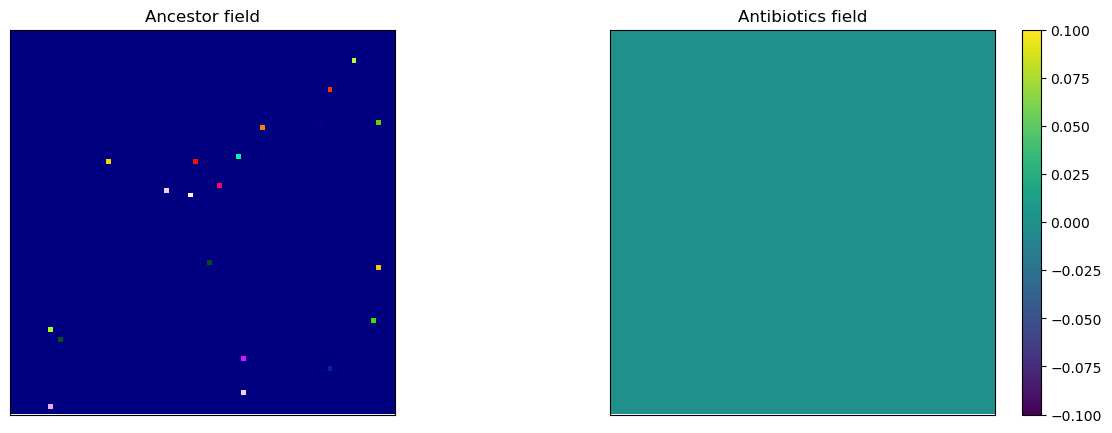

In [559]:
genome_field,antibiotics_field = generate_random_field(field_size=field_size, n_cells=20)
show_population(genome_field,antibiotics_field)

## Cell behaviours


In [560]:
def cell_copy(genome_field,antibiotics_field, cell, new_location):
    # These functions directly act on genome field and antibiotics field
    # Copy one cell to a new location, retain anscestorial history
    new_cell = cell.born_cell(new_location)
    new_cell = genome_mutation(new_cell) # genome mutatuion is added here
    nx = new_location[0]
    ny = new_location[1]
    genome_field[nx,ny] = new_cell
    # antibiotics_field[nx,ny] = np.append(antibiotics_field[nx,ny],new_cell.get_ABR())
    
    return genome_field, antibiotics_field

def cell_replication(genome_field,antibiotics_field, cell):
    # These functions directly act on genome field and antibiotics field
    # Replicate a cell to a neighbouring location
    neighbourhood_vectors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    nx = cell.get_location()[0]
    ny = cell.get_location()[1]
    np.random.shuffle(neighbourhood_vectors)
    for v in neighbourhood_vectors:
        dx = v[0]
        dy = v[1]
        if nx+dx >= 0 and nx+dx < genome_field.shape[0] and ny+dy >= 0 and ny+dy < genome_field.shape[1]:
            if genome_field[nx+dx,ny+dy] is None:
                genome_field, antibiotics_field = cell_copy(genome_field,antibiotics_field, cell, (nx+dx,ny+dy))
                break
    
    return genome_field, antibiotics_field

        
def cell_death(genome_field,antibiotics_field, cell, location):
    # These functions directly act on genome field and antibiotics field
    # Kill
    genome_field[location[0],location[1]] = None

    return genome_field, antibiotics_field

def cell_move(genome_field,antibiotics_field, cell, new_location):
    # These functions directly act on genome field and antibiotics field
    # Move to a new location
    nx = new_location[0]
    ny = new_location[1]
    genome_field[nx,ny] = cell
    # antibiotics_field[nx,ny] = np.append(antibiotics_field[nx,ny],cell.get_ABR())
    genome_field[cell.get_location()[0],cell.get_location()[1]] = None

    return genome_field, antibiotics_field

In [561]:
def is_cell_move(genome_field, location):
    if genome_field[location[0],location[1]] is None:
        return True
    else:
        return False
    
def is_cell_death(genome_field, location):
    if genome_field[location[0],location[1]] is not None:
        return True
    else:
        return False
    


In [562]:
def calculate_radius_vectors(radius):
    radius_vectors = []
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            if i**2+j**2 <= radius**2:
                radius_vectors.append((i,j))
    return radius_vectors

def antibiotics_secretion(genome_field,antibiotics_field, cell, radius_vectors):
    # this is the function for producing antibiotics
    nx = cell.get_location()[0]
    ny = cell.get_location()[1]
    abr = cell.get_ABR()
    ab_gene = np.random.choice(cell.get_ABR()) 
    for vec in radius_vectors:
        dx = vec[0]
        dy = vec[1]
        
        if nx+dx >= 0 and nx+dx < genome_field.shape[0] and ny+dy >= 0 and ny+dy < genome_field.shape[1]:
            if antibiotics_field[nx+dx,ny+dy] is None:
                antibiotics_field[nx+dx,ny+dy] = np.array([ab_gene])
            else:
                if np.isin(ab_gene, antibiotics_field[nx+dx,ny+dy]):
                    continue
                else:
                    antibiotics_field[nx+dx,ny+dy] = np.append(antibiotics_field[nx+dx,ny+dy],ab_gene)

    
    return genome_field, antibiotics_field

In [563]:
# def select_random_cell(genome_field): this is too slow so not used any more
#     # Select a random cell from the field
#     populate = True
#     while populate:
#         i = np.random.randint(0, genome_field.shape[0])
#         j = np.random.randint(0, genome_field.shape[1])
#         if genome_field[i,j] is not None:
#             populate = False
    
#     return (i,j), genome_field[i,j]

def select_random_cell(genome_field):
    # Select a random cell from the field
    cells = get_all_cells(genome_field)
    cell = np.random.choice(cells)
    location = cell.get_location()
    return location, cell

def get_all_cells(genome_field):
    cells = []
    for i in range(genome_field.shape[0]):
        for j in range(genome_field.shape[1]):
            if genome_field[i,j] is not None:
                cells.append(genome_field[i,j])
    return cells

Total NO. of Cells in System is 10


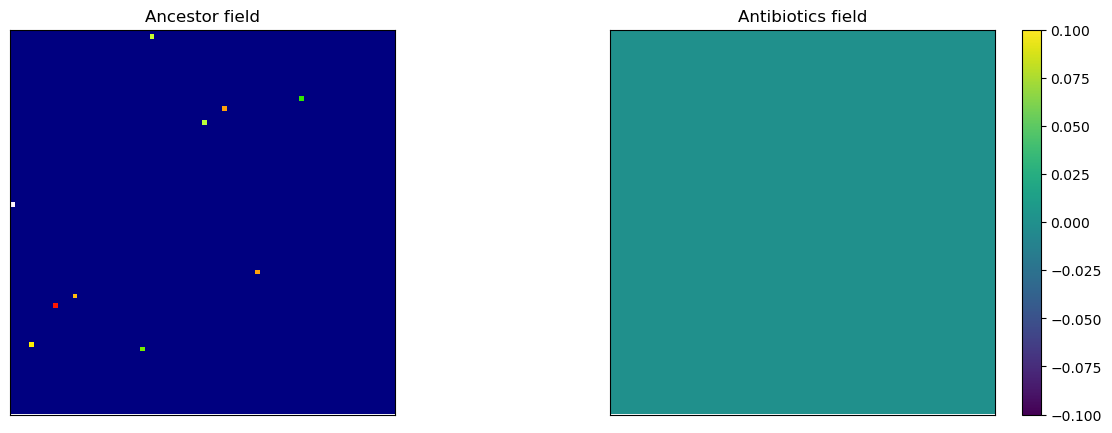

Total NO. of Cells in System is 10


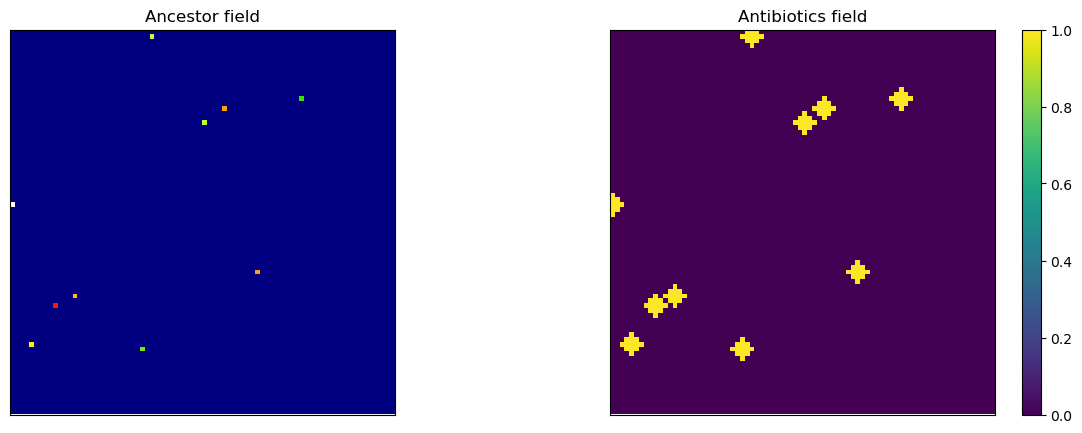

In [564]:
# Test antibiotic secretion
r_a = 2
r_2 = calculate_radius_vectors(r_a)

genome_field,antibiotics_field = generate_random_field(field_size=field_size, n_cells=10)
show_population(genome_field,antibiotics_field)
cells = get_all_cells(genome_field)
for cell in cells:
    genome_field,antibiotics_field = antibiotics_secretion(genome_field,antibiotics_field, cell, r_2)

show_population(genome_field,antibiotics_field)


In [565]:
cell1 = get_all_cells(genome_field)[0]
print(cell1.get_ABR())
abr = antibiotics_field[cell1.get_location()[0],cell1.get_location()[1]]
print(antibiotics_field[0,0])
print(abr)

[21640. 21714. 15597. 36242.  7070. 54884.]
None
[15597.]


In [566]:
calc_death_prob

<function __main__.calc_death_prob(genome_field, antibiotics_field, cell, alpha_g, h_g, beta_r)>

Total NO. of Cells in System is 20


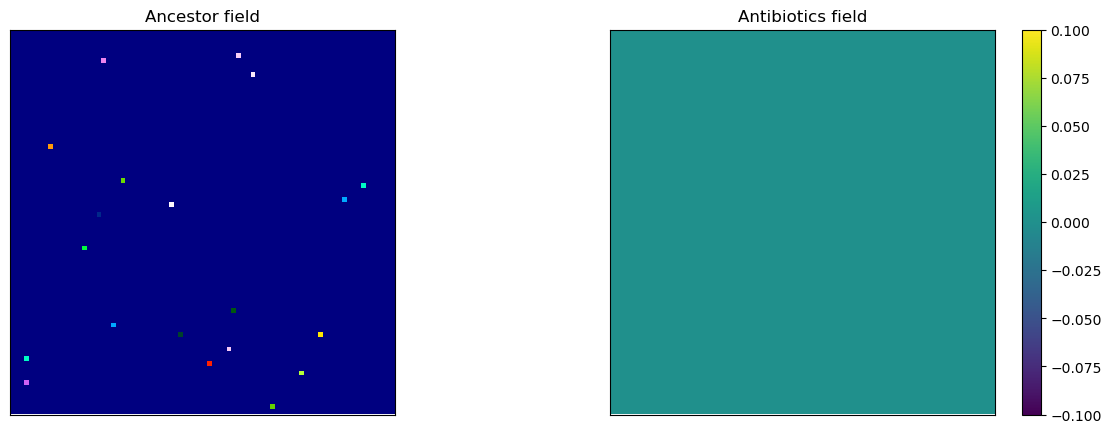

ValueError: 'a' cannot be empty unless no samples are taken

In [567]:
# Test the cell replication
genome_field,antibiotics_field = generate_random_field(field_size=field_size, n_cells=20)
show_population(genome_field,antibiotics_field)

for _ in range(2000):
    coordinate,cell = select_random_cell(genome_field)
    genome_field, antibiotics_field = cell_replication(genome_field,antibiotics_field, cell)

cells = get_all_cells(genome_field)
for cell in cells:
    genome_field,antibiotics_field = antibiotics_secretion(genome_field,antibiotics_field, cell, vec_r_a)

show_population(genome_field,antibiotics_field)

## Genome Behavior

In [ ]:
def which_abr(cell, locus):
    # this function is to find the resistance correspond to a antibiotic gene in genome
    genome = cell.get_genome()
    antibiotics = cell.antibiotics
    
    i = np.count_nonzero(genome[:locus] == 'A')
    abr = antibiotics[i-1]
    return i, abr
def gene_duplication(cell, gene_locus): # this function may be problematic
    """
    Caution!!!
    For unknown reason, this function will not work properly
    but for now it is functional and will be used in the code
    """

    # Duplicate a gene in the genome at a random insertion site
    insertion_site = np.random.randint(0, len(cell.genome))
    
    # If the gene is an antibiotic gene ('A'), duplicate its corresponding antibiotic entry
    if cell.genome[gene_locus] == 'A':
        i,abr = which_abr(cell, gene_locus)
        cell.antibiotics = np.insert(cell.antibiotics, i, abr)

    # Insert the gene at the new location
    cell.genome = np.insert(cell.genome, insertion_site, cell.genome[gene_locus])


    return cell


def gene_deletion(cell,gene_locus):
    # Delete a gene in the genome
    # The gene will be deleted from the genome, and the corresponding antibiotics gene will also be deleted
    if cell.genome[gene_locus] == 'A':

        i, abr = which_abr(cell, gene_locus)
        cell.antibiotics = np.delete(cell.antibiotics, i)

    cell.genome = np.delete(cell.genome, gene_locus)
    
    return cell



def fragile_deletion(cell,gene_locus):
    # Delete a fragile gene in the genome
    # The fragile gene and all genes after it will be deleted from the genome
    if cell.genome[gene_locus] == 'F':
        i, abr = which_abr(cell, gene_locus)
        # Get indices to delete
        cell.genome = cell.genome[:gene_locus]
        # Count antibiotics genes before fragile site
        if i == 0:
            cell.antibiotics = []
        else:
            cell.antibiotics = cell.antibiotics[:i]
        return cell

    else:
        return 0
    
    

def fragile_generation(cell):
    # Generate a fragile gene in the genome
    # The fragile gene will be inserted at a random location in the genome
    gene_locus = np.random.randint(0, len(cell.genome))
    cell.genome = np.insert(cell.genome, gene_locus, 'F')
    return cell

def antibiotics_mutation(cell):
    # Mutate the antibiotics gene in the genome
    # The antibiotics gene will be mutated by a random mutation
    while True:
        gene_locus = np.random.randint(0, len(cell.genome))
        if cell.genome[gene_locus] == 'A':
            break
    i = np.count_nonzero(cell.genome[:gene_locus] == 'A')
    cell.antibiotics[i].uniform_mutate()
    return cell



In [ ]:
cell1 = BacteriaCell(location=(0,0),ancestors=[np.random.randint(0, 0xFFFFFF)], gen_random=False, genome_size=7, genome=['G','G', 'G',  'A', 'A', 'F', 'A'])
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())



['G' 'G' 'G' 'A' 'A' 'F' 'A']
3
[50153. 30892. 44896.]


In [ ]:
for i in range(len(cell1.genome)):
    print(cell1.genome[0:i+1],which_abr(cell1, i)[0])


['G'] 0
['G' 'G'] 0
['G' 'G' 'G'] 0
['G' 'G' 'G' 'A'] 0
['G' 'G' 'G' 'A' 'A'] 1
['G' 'G' 'G' 'A' 'A' 'F'] 2
['G' 'G' 'G' 'A' 'A' 'F' 'A'] 2


In [ ]:
print(cell1.count_genes('A'))
print(cell1.count_genes('G'))
print(cell1.count_genes('F'))

3
3
1


In [ ]:
cell1 = gene_duplication(cell1, 3)
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())

['G' 'G' 'G' 'A' 'A' 'A' 'F' 'A']
4
[44445. 44445.  6037. 52891.]


In [ ]:
cell1 = gene_deletion(cell1, 1)
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())

['G' 'G' 'A' 'A' 'A' 'F' 'A']
4
[44445. 44445.  6037. 52891.]


In [ ]:
cell1 = fragile_generation(cell1)
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())

['G' 'F' 'G' 'G' 'A' 'A' 'F' 'A']
3
[50153. 30892. 44896.]


In [ ]:
cell1 = antibiotics_mutation(cell1)
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())

['G' 'G' 'F' 'A' 'A' 'A' 'F' 'A']
4
[28592. 28592.  6037. 52891.]


In [ ]:
cell1 = fragile_deletion(cell1, 0)
print(cell1.genome)
print(len(cell1.antibiotics))
print(cell1.get_ABR())

['G']
0
[]


## Probability calculation

In [ ]:
def genome_mutation(cell, mu_a = 0.005, mu_d = 0.001, mu_f = 0.01, mu_n = 0.01):
    # Mutate the genome of a cell
    # 
    n_A = cell.count_genes('A')
    n_G = cell.count_genes('G')
    n_F = cell.count_genes('F')
    n_genes = len(cell.genome)
    # Duplication and deletion
    # only one event can happen at a time
    for i in range(n_genes):
        if cell.genome[i] == 'A':
            if np.random.rand() < mu_a:
                cell = antibiotics_mutation(cell)
                break
        if np.random.rand() < mu_d:
            cell = gene_duplication(cell, i)
            break
        if np.random.rand() < mu_d:
            pass
            cell = gene_deletion(cell, i)
            break
        if np.random.rand() < mu_f:
            tmp_cell = fragile_deletion(cell, i)
            if tmp_cell != 0:
                cell = tmp_cell
                break
        

    # Fragile site generation
    if np.random.rand() < mu_n:
        cell = fragile_generation(cell)

    return cell


In [ ]:
cell = BacteriaCell(location=(0,0),ancestors=[np.random.randint(0, 0xFFFFFF)], gen_random=True, genome_size=5)
print(cell.genome)
print(len(cell.genome))
print(len(cell.antibiotics))
print(cell.get_ABR())

cell = genome_mutation(cell, mu_a = 0, mu_d = 1, mu_f = 0, mu_n = 0)
print(cell.genome)
print(len(cell.genome))
print(len(cell.antibiotics))
print(cell.get_ABR())


['G' 'F' 'G' 'G' 'G']
5
0
[]
['G' 'G' 'F' 'G' 'G' 'G']
6
0
[]


In [ ]:
def hamming_distance(a,b):
    # Calculate the hamming distance between two bit strings
    return bin(a^b).count('1')

def calc_antibiotics_resistance(genome_field,antibiotics_field,cell, beta_r):
    # Calculate the resistance of a cell to antibiotics using hamming distance
    # For each antibiotic gene in cell:
    #   Find minimum hamming distance to any antibiotic in the environment
    #   Add minimum distance to total resistance
    # Return exp(-beta_r * resistance^2) as final resistance probability
    # Lower hamming distance means more similar antibiotics and lower resistance
    cell_antibiotics = cell.get_ABR()
    s = 0
    block_antibiotics = antibiotics_field[cell.get_location()[0],cell.get_location()[1]]
    for i in range(len(cell_antibiotics)):
        min_d = 0
        if block_antibiotics is None:
            block_antibiotics = []
        for j in range(len(block_antibiotics)):

            dist = hamming_distance(cell_antibiotics[i],block_antibiotics[j])
            if dist < min_d:
                min_d = dist
        s += min_d 

    
    
    return np.exp(-beta_r * s^2)
    

def calc_rep_prob(genome_field,antibiotics_field,cell, alpha_g, h_g, beta_r):
    # Calculate the probability of replication of a cell
    # The probability of replication is a function of the number of growth genes in the genome
    # and the number of antibiotics genes in the genome
    n_G = cell.count_genes('G')
    R = calc_antibiotics_resistance(genome_field,antibiotics_field,cell, beta_r)
    return alpha_g * R * n_G / (h_g + n_G) 

def calc_death_prob(genome_field,antibiotics_field,cell, alpha_g, h_g, beta_r):
    # Calculate the probability of death of a cell
    # The probability of death is a function of the number of growth genes in the genome
    # and the number of antibiotics genes in the genome
    R = calc_antibiotics_resistance(genome_field,antibiotics_field,cell, beta_r)
    return 1 - R
    
def calc_ab_prob(genome_field,antibiotics_field,cell, alpha_a,h_a, beta_g):
    # Calculate the probability of antibiotics production of a cell
    # The probability of antibiotics production is a function of the number of antibiotics genes in the genome
    n_A = cell.count_genes('A')
    n_G = cell.count_genes('G')
    return alpha_a * n_A / (h_a + n_A) * np.exp(-beta_g * n_G)

In [ ]:
def cell_activity(genome_field,antibiotics_field,cell):
    # Calculate the activity of a cell
    # The activity of a cell is a function of the number of growth genes in the genome
    # and the number of antibiotics genes in the genome
    abr = calc_antibiotics_resistance(genome_field,antibiotics_field,cell, beta_r)
    rep_prob = calc_rep_prob(genome_field,antibiotics_field,cell, alpha_g, h_g, beta_r)
    death_prob = calc_death_prob(genome_field,antibiotics_field,cell, alpha_g, h_g, beta_r)
    ab_prob = calc_ab_prob(genome_field,antibiotics_field,cell, alpha_a,h_a, beta_g)
    try:
        if np.random.rand() < rep_prob:
            genome_field, antibiotics_field = cell_replication(genome_field,antibiotics_field, cell)
        if np.random.rand() < death_prob:
            genome_field, antibiotics_field = cell_death(genome_field,antibiotics_field, cell, cell.get_location())
        if np.random.rand() < ab_prob:
            genome_field, antibiotics_field = antibiotics_secretion(genome_field,antibiotics_field, cell, vec_r_a)

    except:
        pass
    return genome_field, antibiotics_field

    

Total NO. of Cells in System is 20


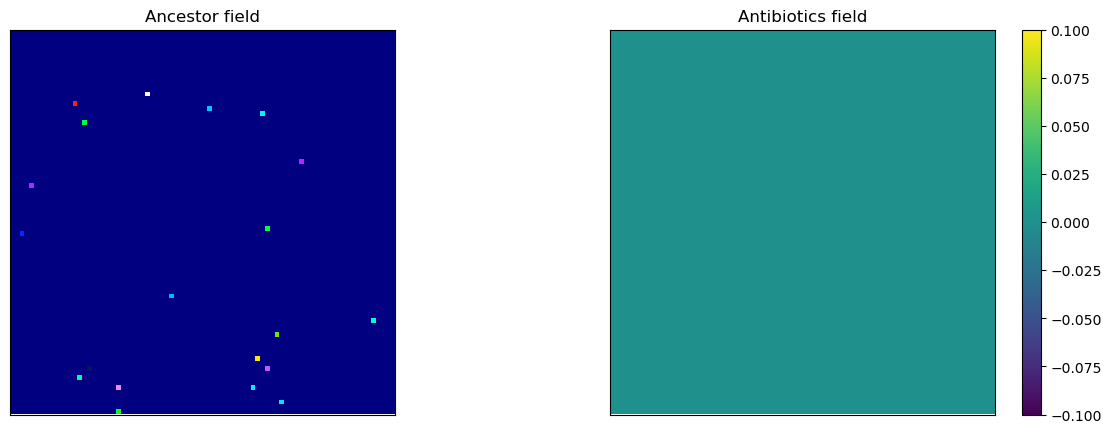

TypeError: object of type 'NoneType' has no len()

In [ ]:
genome_field,antibiotics_field = generate_random_field(field_size=field_size, n_cells=20)
show_population(genome_field,antibiotics_field)

for _ in range(2000):
    coordinate,cell = select_random_cell(genome_field)
    genome_field, antibiotics_field = cell_activity(genome_field,antibiotics_field, cell)

show_population(genome_field,antibiotics_field)
